In [1]:
import os,sys, torchaudio, torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

wav = 'data1/train/train_00001_m_01_0.wav' #  https://github.com/soerenab/AudioMNIST
# wav = 'wav/audio1.wav' # https://en.wikipedia.org/wiki/Singing
# wav = 'wav/audio2.wav' # https://www.chineasy.com/mandarin-chinese-pronunciation-an-introduction/

# Waveform

Read and plot the waveform of a wav file.

In [2]:
x, fs = torchaudio.load(wav)
print(x.shape)
torchaudio.save('out/waveform.wav', x, fs)

torch.Size([1, 10403])


# Noise augmentation

Add noise to the waveform with a snr of 5dB.

In [3]:
n, fs2 = torchaudio.load('musan_small/music_small/music-jamendo-0090.wav')
assert fs == fs2

t0 = np.random.randint(0, n.shape[1] - x.shape[1])
n = n[:, t0:t0+x.shape[1]]

p_x = x.std()**2
p_n = n.std()**2
print(p_x, p_n)
print(len(x[0].numpy()), len(n[0].numpy()))
snr = 5


n = n * np.sqrt(p_x/p_n) * np.power(10, -snr/20)

p_x = x.std()**2
p_n = n.std()**2
print(p_x, p_n, 10*np.log10(p_x/p_n))
x_n = x + n

torchaudio.save('out/waveform_noise.wav', x_n, fs)

tensor(2.3474e-05) tensor(0.0477)
10403 10403
tensor(2.3474e-05) tensor(7.4231e-06) tensor(5.)


# RIR augmentation

Add a room impulse response (RIR) to the waveform.

(16000,) 16000


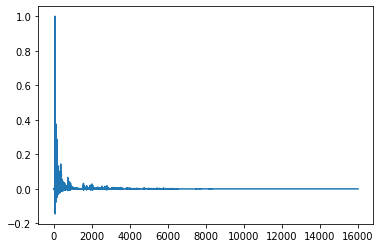

In [4]:
h, fs2 = torchaudio.load('RIRS_NOISES_small/simulated_rirs_small/mediumroom_Room030-00003.wav')
h = h[0].numpy()
h = h / np.max(np.abs(h))

print(h.shape, fs2)
assert fs == fs2

plt.clf()
plt.plot(h)


x_h = scipy.signal.convolve(x[0].numpy(), h)

torchaudio.save('out/waveform_rir1.wav', torch.tensor(x_h)[None,...], fs)

RIR augmentation: simulator

Add a room impulse response (RIR) to the waveform using a room simulator.
https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.room.html

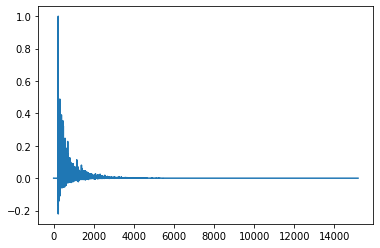

In [5]:
# os.system('pip install pyroomacoustics')
import pyroomacoustics as pra

# The desired reverberation time and dimensions of the room
rt60_tgt = 0.3  # seconds
room_dim = [10, 7.5, 3.5]  # meters

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

# place the source in the room
room.add_source([2.5, 3.73, 1.76], signal=x[0].numpy(), delay=0.5)

# define the locations of the microphones
mic_locs = np.c_[
    [6.3, 4.87, 1.2], [6.3, 4.93, 1.2],  # mic 1  # mic 2
]

# finally place the array in the room
room.add_microphone_array(mic_locs)

# Run the simulation (this will also build the RIR automatically)
room.simulate()
h = room.rir[1][0]
h = h / np.max(np.abs(h))

plt.clf()
plt.plot(h)

x_h = scipy.signal.convolve(x[0].numpy(), h)

torchaudio.save('out/waveform_rir2.wav', torch.tensor(x_h)[None,...].float(), fs)